*Пятый проект.*

Здесь лежит весь код на python и sql.

In [4]:
# Загрузка и обработка данных для последующей работы.
import pandas as pd
import numpy as np

df = pd.read_csv('raw_data/yellow_tripdata_2020-01.csv') 
df = df.drop(['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type', 
          'extra', 'mta_tax', 'tolls_amount', 'improvement_surcharge', 'congestion_surcharge'], axis=1) 

df["passenger_count"].replace('', np.nan, inplace=True) 
df.dropna(subset=["passenger_count"], inplace=True)
df["passenger_count"] = df['passenger_count'].astype('int') 

df.to_csv('raw_data/yellow_tripdata_itog.csv', index=False)
df

C:\Users\konni\AppData\Local\Temp\ipykernel_13896\4165895782.py:5: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('raw_data/yellow_tripdata_2020-01.csv')


,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,tip_amount,total_amount
0,2020-01-01 00:28:15,2020-01-01 00:33:03,1,1.20,6.0,1.47,11.27
1,2020-01-01 00:35:39,2020-01-01 00:43:04,1,1.20,7.0,1.50,12.30
2,2020-01-01 00:47:41,2020-01-01 00:53:52,1,0.60,6.0,1.00,10.80
3,2020-01-01 00:55:23,2020-01-01 01:00:14,1,0.80,5.5,1.36,8.16
4,2020-01-01 00:01:58,2020-01-01 00:04:16,1,0.00,3.5,0.00,4.80
...,...,...,...,...,...,...,...
6339562,2020-01-31 23:38:07,2020-01-31 23:52:21,1,2.10,11.0,2.96,17.76
6339563,2020-01-31 23:00:18,2020-01-31 23:19:18,1,2.13,13.0,3.36,20.16
6339564,2020-01-31 23:24:22,2020-01-31 23:40:39,1,2.55,12.5,3.26,19.56
6339565,2020-01-31 23:44:22,2020-01-31 23:54:00,1,1.61,8.5,0.00,12.30


In [ ]:
-- Создание первой витрины с процентами поездок по количеству человек.
create table if not exists mart as
with first_tab (trip_date, passanger_count, passanger_set, trip_distance, fare_amount, tip_amount, total_amount) as (
select 
	date(tpep_pickup_datetime), passanger_count,
	case 
		when passanger_count = 0 then '0_pas'
		when passanger_count = 1 then '1_pas'
		when passanger_count = 2 then '2_pas'
		when passanger_count = 3 then '3_pas'
		else '4_pas_plus'
	end as passanger_set, trip_distance, fare_amount, tip_amount, total_amount
from work_table
where trip_distance > 0 and trip_distance < 250 and -- ограничение для дальности поездок, чтобы отсечь выбросы
	  tip_amount > 0 and -- часто встречаются отрицательные значения тех или иных значений, поэтому их тоже отсекаю
	  total_amount > 0 and
	  fare_amount > 0 and 
	  tpep_pickup_datetime >= '2020-01-01' and tpep_pickup_datetime <= '2020-01-31' -- устанавливаю ограничение только за один месяц, потому что
	  -- в самом источнике данных попадаются данные за январи других годов.
),
second_tab (trip_date, passanger_set, passanger_count ) as (
select trip_date, passanger_set,
	count(passanger_count)
from first_tab
group by trip_date, passanger_set
),
third_tab (trip_date, passanger_set, percents) as (
select trip_date, passanger_set,
	round(passanger_count / sum(passanger_count) over (partition by trip_date), 4) * 100
from second_tab
),
fourth_tab (trip_date, passanger_set, 
percentage_zero, percentage_1p, percentage_2p, percentage_3p, percentage_4p_plus) as (
select trip_date, passanger_set,
	case when passanger_set like '0_pas' then percents else NULL end,
	case when passanger_set like '1_pas' then percents else NULL end,
	case when passanger_set like '2_pas' then percents else NULL end,
	case when passanger_set like '3_pas' then percents else NULL end,
	case when passanger_set like '4_pas_plus' then percents else NULL end
from third_tab
),
fifth_tab (trip_date, passanger_set, total_amount_min, total_amount_max) as (
select distinct trip_date, passanger_set,
	min(total_amount) over (partition by trip_date, passanger_set),
	max(total_amount) over (partition by trip_date, passanger_set)
from first_tab
)
select trip_date,  percentage_zero, percentage_1p, percentage_2p, percentage_3p, percentage_4p_plus,
		total_amount_min,total_amount_max
from fourth_tab join fifth_tab using(trip_date, passanger_set)
order by trip_date;

In [ ]:
-- Создание второй витрины данных для графика зависимости чаевых от дальности поездки.
create table if not exists mart_1 as
with help_tab (passanger_count, trip_distance, trip_grip, tip_amount) as (
select passanger_count, trip_distance,
	case 
		when trip_distance < 10 then '0-10'
		when trip_distance < 20 then '10-20'
		when trip_distance < 30 then '20-30'
		when trip_distance < 40 then '30-40'
		when trip_distance < 50 then '40-50'
		when trip_distance < 60 then '50-60'
		when trip_distance < 70 then '60-70'
		when trip_distance < 80 then '70-80'
		when trip_distance < 90 then '80-90'
		when trip_distance < 100 then '90-100'
		else 'более 100'
	end,	
	tip_amount
from work_table wt 
)
select passanger_count, trip_grip, 
	avg(tip_amount) as average_tip_amount
from help_tab
group by passanger_count, trip_grip
order by passanger_count, trip_grip

Connected succesfully
Connection closed


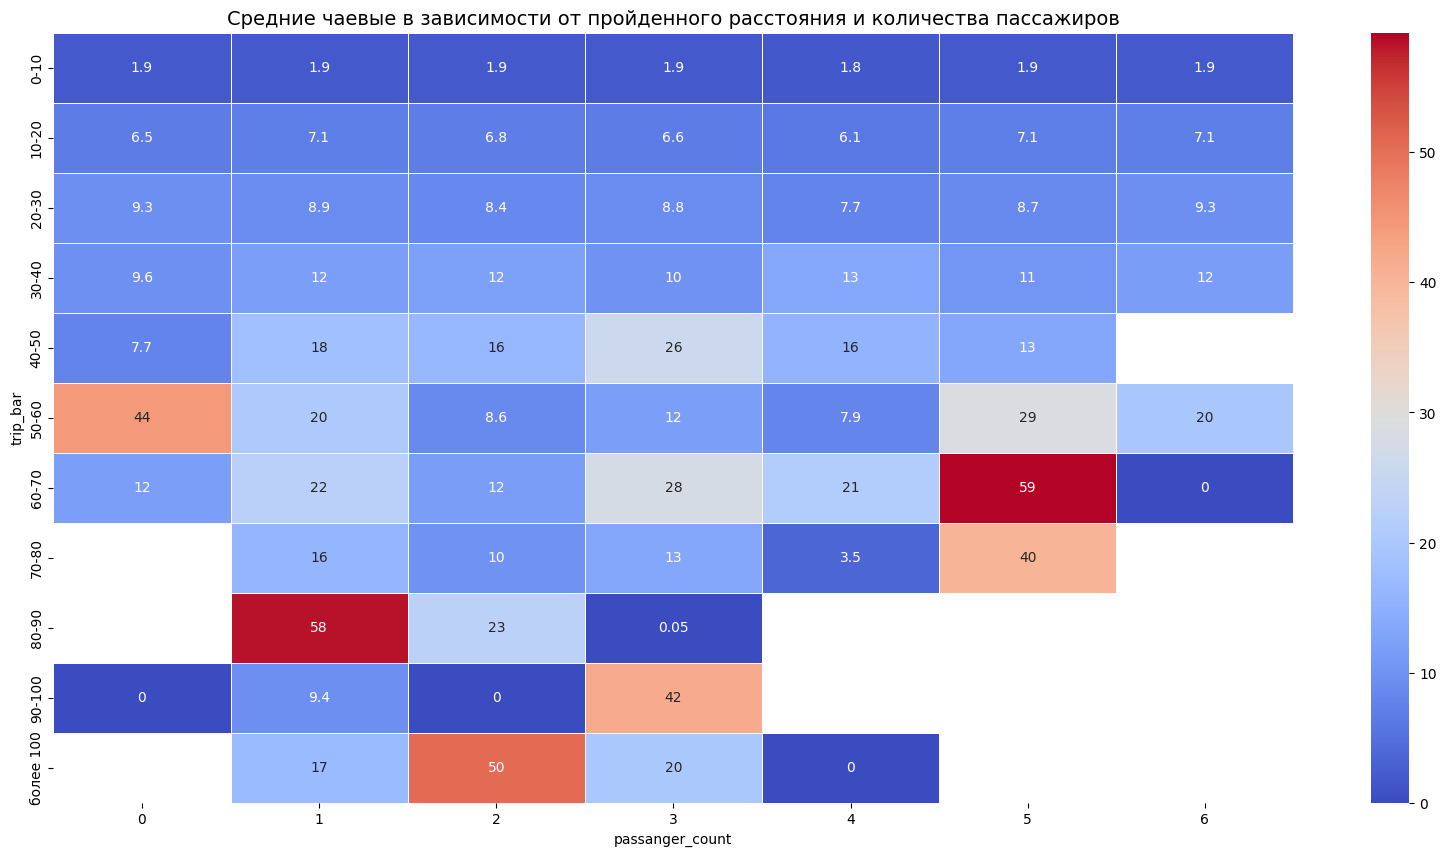

In [6]:
# Обработка результата и его вывод:
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

try:
    connection = psycopg2.connect(
        host = 'localhost',
        port = '5432',
        user = 'user',
        password = 'secret',
        database = 'db_itog'
    )

    print("Connected succesfully")
    cursor = connection.cursor()
    cursor.execute('''SELECT * FROM mart''')

    mart_info = cursor.fetchall()
    df = pd.DataFrame(mart_info, columns=['date', 
                              'percentage_zero', 
                              'percentage_1p', 
                              'percentage_2p',
                              'percentage_3p',
                              'percentage_4p_plus',
                              'total_min',
                              'total_max'
                             ])
    
    df.to_parquet("D:\\Git_reps\\data1t\\Final task\\out\\mart.parquet", engine='pyarrow', index=False)  

    cursor.execute('''SELECT * FROM mart_1''')
    mart_info_1 = cursor.fetchall()

    frame = pd.DataFrame(mart_info_1, columns=['passanger_count', 'trip_bar', 'average_tip'])
    frame = frame.pivot(index='trip_bar', values='average_tip', columns='passanger_count')

    fig, axes = plt.subplots(figsize=(20, 10))
    pivot = sns.heatmap(data=frame, cmap="coolwarm", annot=True, linewidths=.5)
    pivot.set_title('Средние чаевые в зависимости от пройденного расстояния и количества пассажиров', fontsize=14)
    
except (Exception) as error:
    print("Error when using PostgreSQL", error)

finally:
    if connection:
        cursor.close()
        connection.close()
        print("Connection closed")